# Simulate differential accessibility

## Intro
### High peak variance as an indicator of differential accessibility
- One of the most important goals of count normalization is the stabilization of variance.
- Ideally peaks that show high variance would also be diffentially accessible (DA).
- To test for that we will simulate differentially accessible peaks using simATAC.

## Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

import scanpy as sc
import episcanpy as epi
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import rpy2.robjects as ro
import scipy.stats as stats
import sklearn
import pandas as pd
import epinorm.data as data
import epinorm.simulation as sim
import epinorm.normalization as norm
import epinorm.diffacc as diffacc
import epinorm.plots as myplt

## Load filtered data

In [2]:
file_path=Path('../data/mouse_brain_5k/bin_by_cell_filtered.h5ad')
run = 'S5'
cfg_path = "../data/simulation/templates/template20220205.json"

In [3]:
epidata = data.MouseBrainDataset(root='../')
adata = epidata.load_mtx(matrix_path=file_path)

In [ ]:
adata.obs['cell_type'].unique()

## Simulate data

### Simulation parameters
- l...library size per cell
- m...accessibility per peak

![simatac](./media/simatac.png)

### Steps

1) Use simATAC to estimate the distribution parameters of a given dataset
2) Load differential accessibility (DA) configuration
3) Use DA config to modify the estimated distribution from 1)
    - different combinations of library size (l) and peak mean (m) can make it harder to estimate DA
    - For example you could mask DA by increasing the the library size
4) Simulate new datasets using the different sets of estimated parameters
5) The resulting datasets should be differentially accessible based on the given DA config

In [4]:
def estimated_params(mouse_brain_adata) -> sim.Params:
    mouse_brain_adata = mouse_brain_adata[mouse_brain_adata.obs['cell_type'] == 'L5 IT']
    with sim.Simulator() as simulator:
        return simulator.estimate(mouse_brain_adata)

In [5]:
adata = adata[adata.obs['cell_type'] == 'L5 IT']
# load DA config 
# todo read JSON file
cfg = diffacc.config.DAConfig.from_template(cfg_path)[run]
# estimate params
params = estimated_params(adata)

In [6]:
for k, cg in cfg.cell_groups.items():
    print(f'{k}; lib_mean = {cg.lib_mean}')
    for acc in cg.accessibilities:
        print(acc)

C_CONTROL; lib_mean = 14
DAAccessibility(feature_group_id='F_1', score=0.01)
DAAccessibility(feature_group_id='F_2', score=0.4)
DAAccessibility(feature_group_id='F_3', score=0.7)
C_1; lib_mean = 15
DAAccessibility(feature_group_id='F_1', score=0.3)
DAAccessibility(feature_group_id='F_2', score=0.8)
DAAccessibility(feature_group_id='F_3', score=0.98)
C_2; lib_mean = 13
DAAccessibility(feature_group_id='F_1', score=0.3)
DAAccessibility(feature_group_id='F_2', score=0.8)
DAAccessibility(feature_group_id='F_3', score=0.98)


In [7]:
adata_sim = sim.simulate_da(params=params, config=cfg)
adata_sim

AnnData object with n_obs × n_vars = 300 × 15032
    obs: 'Cell', 'LibSize', 'cell_group'
    var: 'feature_group'
    uns: 'simulation_params', 'da_config'

<AxesSubplot: xlabel='feature_group', ylabel='count'>

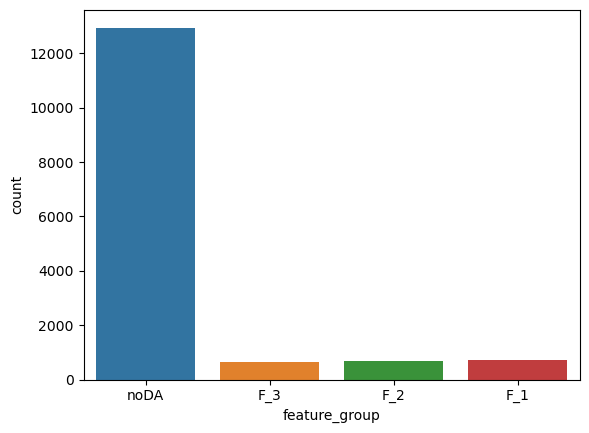

In [8]:
sns.countplot(adata_sim.var, x='feature_group')

## DIfferential accessibility analysis

In [9]:
adata_sim.layers['raw'] = adata_sim.X

In [10]:
norm.log1pPF(adata_sim)

log1pPF_normalization layer added
pf_size_factors layer added


In [11]:
norm.scran(adata_sim)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    scran_normalization layer added
scran_size_factors obs added


In [37]:
norm.sctransform(adata_sim)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


scTransform_normalization layer added


In [68]:
layer="raw"

In [69]:
adata_sim.X = adata_sim.layers[layer]
diffacc.utils.rank_features(adata_sim, groupby='cell_group', reference='C_CONTROL')

scores_C_1 var added
pvals_C_1 var added
pvals_adj_C_1 var added
logfoldchanges_C_1 var added
scores_C_2 var added
pvals_C_2 var added
pvals_adj_C_2 var added
logfoldchanges_C_2 var added


(array([  78., 1251., 3093., 2920., 3376., 2492.,  807.,  623.,  341.,
          51.]),
 array([-10.18693066,  -8.56629467,  -6.94565773,  -5.32502127,
         -3.70438504,  -2.08374858,  -0.46311218,   1.15752423,
          2.77816057,   4.39879704,   6.0194335 ]),
 <BarContainer object of 10 artists>)

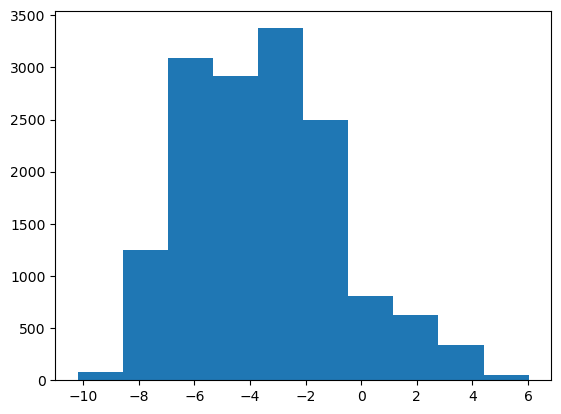

In [70]:
plt.hist(adata_sim.var['scores_C_2'])

In [71]:
res = diffacc.utils.get_rank_results(adata_sim, method=layer, run=run)

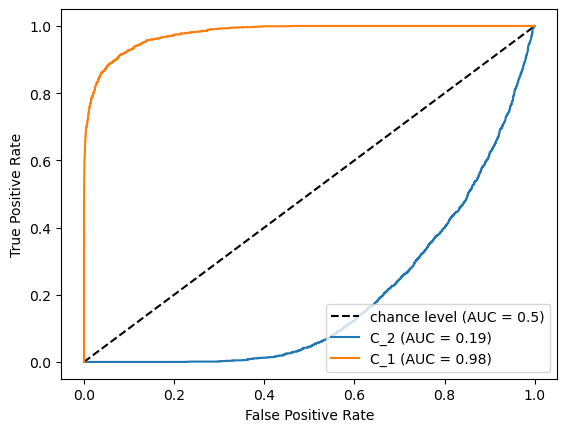

In [72]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
for x in res:
    roc = x.roc
    myplt.plot_roc_curve(fpr=roc.fpr, tpr=roc.tpr, key=roc.cell_group, auc=roc.auc, ax=ax)

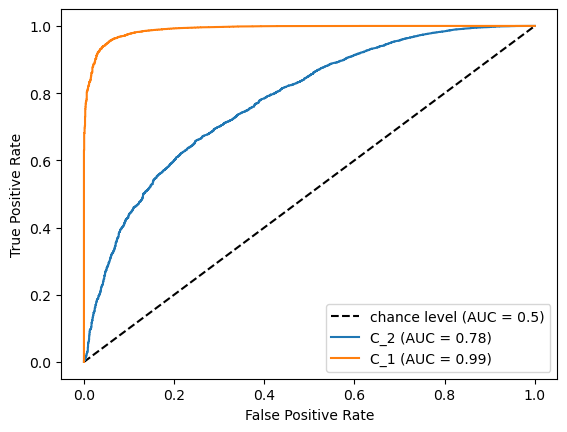

In [30]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
for x in res:
    roc = x.roc
    myplt.plot_roc_curve(fpr=roc.fpr, tpr=roc.tpr, key=roc.cell_group, auc=roc.auc, ax=ax)

## Compare normalization methods

In [39]:
results = diffacc.utils.rank_normalization_methods(adata_sim, run=run)

scores_C_1 var added
pvals_C_1 var added
pvals_adj_C_1 var added
logfoldchanges_C_1 var added
scores_C_2 var added
pvals_C_2 var added
pvals_adj_C_2 var added
logfoldchanges_C_2 var added
scores_C_1 var added
pvals_C_1 var added
pvals_adj_C_1 var added
logfoldchanges_C_1 var added
scores_C_2 var added
pvals_C_2 var added
pvals_adj_C_2 var added
logfoldchanges_C_2 var added
scores_C_1 var added
pvals_C_1 var added
pvals_adj_C_1 var added
logfoldchanges_C_1 var added
scores_C_2 var added
pvals_C_2 var added
pvals_adj_C_2 var added
logfoldchanges_C_2 var added
scores_C_1 var added
pvals_C_1 var added
pvals_adj_C_1 var added
logfoldchanges_C_1 var added
scores_C_2 var added
pvals_C_2 var added
pvals_adj_C_2 var added
logfoldchanges_C_2 var added


In [40]:
adata_sim.layers['scTransform_normalization']

<300x15032 sparse matrix of type '<class 'numpy.float64'>'
	with 4509600 stored elements in Compressed Sparse Row format>

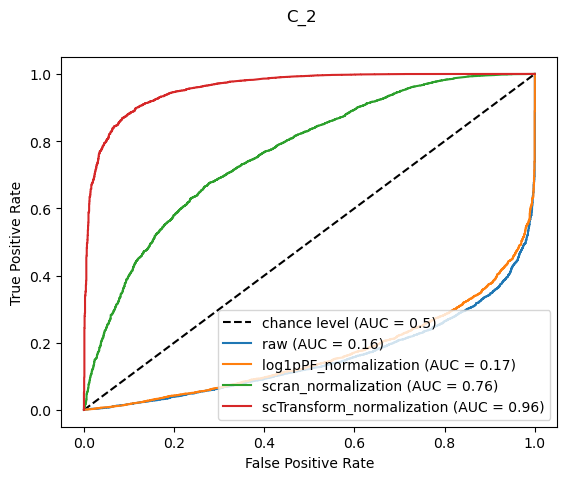

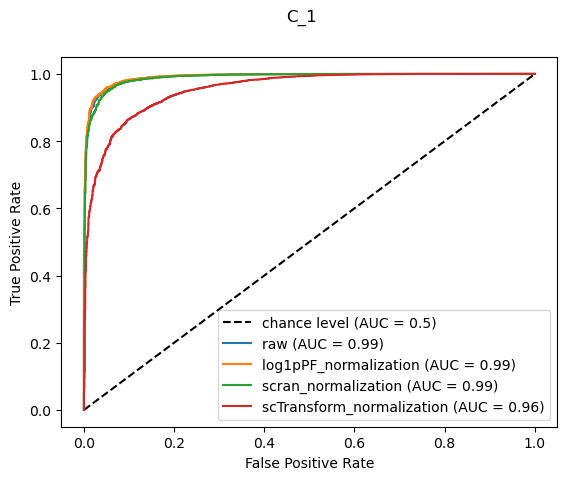

In [41]:
cg_to_roc = {}
for result in results:
    roc = result.roc
    if roc.cell_group not in cg_to_roc:
        cg_to_roc[roc.cell_group] = []
    cg_to_roc[roc.cell_group].append(roc)

for cg, rocs in cg_to_roc.items():
    fig = plt.figure()
    fig.suptitle(cg)
    ax = fig.add_subplot()
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    for roc in rocs:
        myplt.plot_roc_curve(fpr=roc.fpr, tpr=roc.tpr, key=roc.method, auc=roc.auc, ax=ax)

## Visualize DA

In [56]:
features = adata_sim.var_names[adata_sim.var['feature_group'] == 'F_1'][:100]

[Text(0.5, 1.0, 'C_1')]

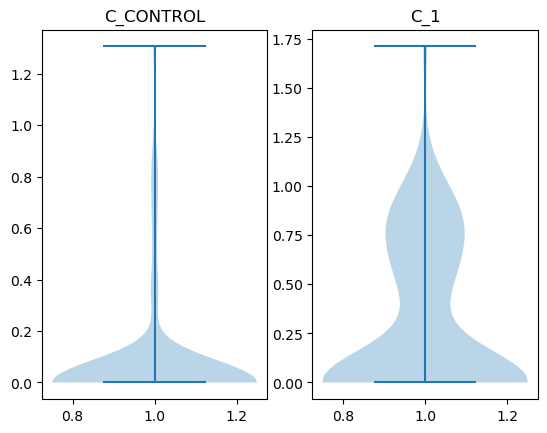

In [57]:
adata_feat = adata_sim[:, features[1]]
g1 = 'C_CONTROL'
g2 = 'C_1'
ca_arr = adata_feat[adata_feat.obs["cell_group"] == g1].X.toarray()
cb_arr = adata_feat[adata_feat.obs["cell_group"] == g2].X.toarray()

fig, ax = plt.subplots(1,2)
ax[0].violinplot(ca_arr)
ax[0].set(title=g1)
ax[1].violinplot(cb_arr)
ax[1].set(title=g2)

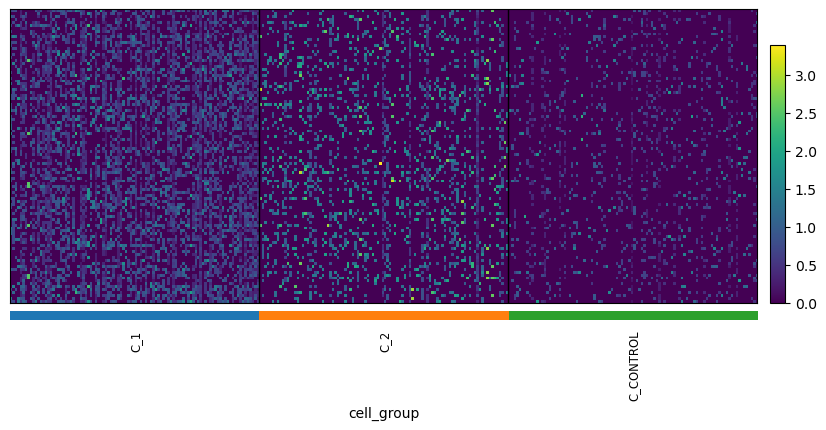

In [58]:
epi.pl.heatmap(adata_sim, groupby='cell_group', var_names=features[:100], swap_axes=True)

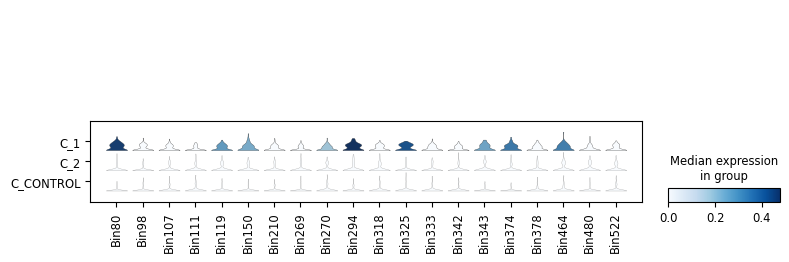

In [59]:
epi.pl.stacked_violin(adata_sim, groupby='cell_group', var_names=features[:20], swap_axes=False)

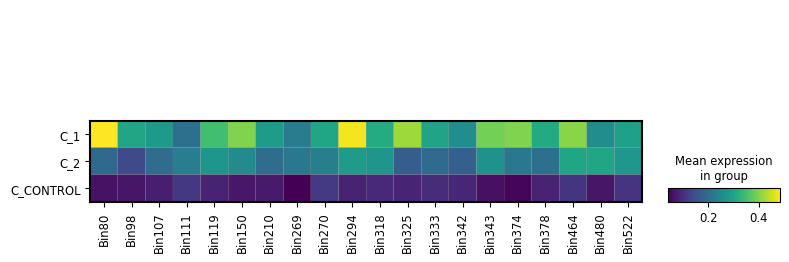

In [60]:
epi.pl.matrixplot(adata_sim, groupby='cell_group', var_names=features[:20], swap_axes=False)

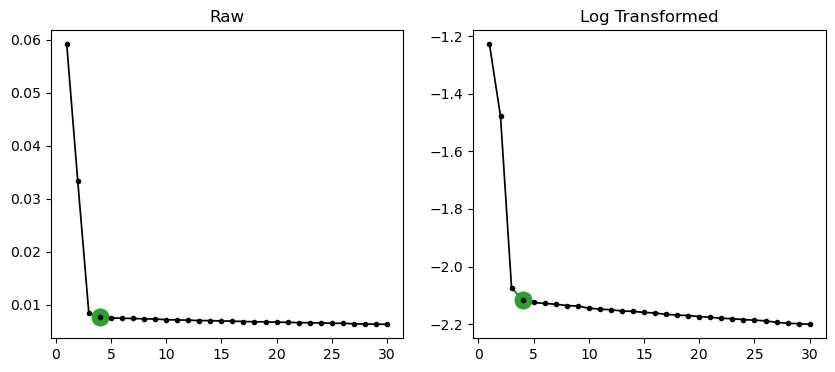

In [61]:
epi.pp.pca(adata_sim, n_comps=30)
n_comps = epi.pp.find_elbow(adata_sim, use_log=True, show_anno=False)

In [62]:
epi.pp.neighbors(adata_sim, n_pcs=n_comps, method="umap")

In [63]:
epi.tl.umap(adata_sim)

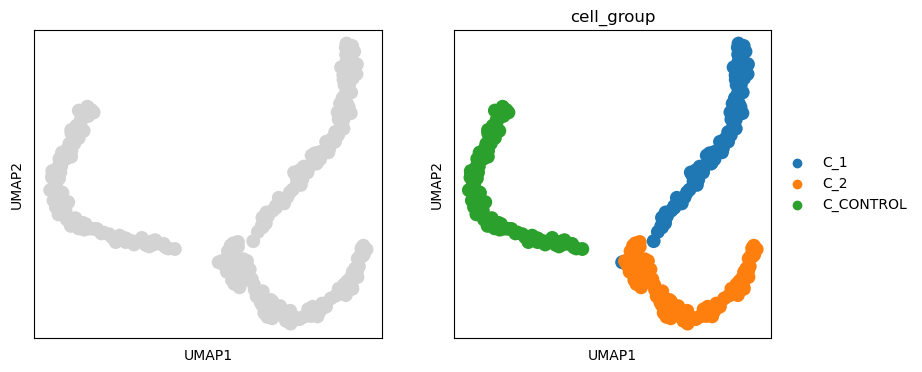

In [64]:
plt.rcParams["figure.figsize"]= (4, 4)
epi.pl.umap(adata_sim, color=[None, "cell_group"])

### Next steps
DA
1) Come up with new DA scenarios
    - no DA
        - same library size
        - different library size
    - high DA
    - moderate DA
2) compute metrics for DA (treat it as a classification task)
3) simulate N times by changing the seed
4) Run different normalizations
5) Test for statistically different results

Clustering
1) simulate different cell types N times
2) Run different normalizations
3) compute silhouette scores
4) Test for statistically different results


+ Install simulator on the server to run simulations